In [1]:
pip install scipy  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 45.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 84.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 54.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import warnings
import itertools
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import calendar
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from datetime import timedelta
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### load and read the datasets

In [4]:
walmart = pd.read_csv('train.csv')

walmart_feature = pd.read_csv('features.csv')

walmart_store = pd.read_csv('stores.csv')

In [5]:
walmart.head()


Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

In [6]:
walmart.shape

(421570, 5)

### Group by store

In [7]:
walmart_store_group=walmart.groupby(["Store","Date"])[["Weekly_Sales"]].sum()
walmart_store_group.reset_index(inplace=True)

### Merging all the datasets into one place for easier analysis.

In [8]:
result = pd.merge(walmart_store_group, walmart_store, how='inner', on='Store', left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)

data = pd.merge(result, walmart_feature, how='inner', on=['Store','Date'], left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)

In [10]:
print(data.shape)

(6435, 15)


##### Dataframe Walmart with 421570 rows has come down to 6435 rows by doing a group by and merge

## Data Cleaning

In [9]:
data.head()

Store        Date  Weekly_Sales Type    Size  Temperature  Fuel_Price  \
0      1  2010-02-05    1643690.90    A  151315        42.31       2.572   
1      1  2010-02-12    1641957.44    A  151315        38.51       2.548   
2      1  2010-02-19    1611968.17    A  151315        39.93       2.514   
3      1  2010-02-26    1409727.59    A  151315        46.63       2.561   
4      1  2010-03-05    1554806.68    A  151315        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment  IsHoliday  
0         8.106      False  
1         8.106       True  
2         8.106      False  
3         8.106      False  
4         8.106      False

In [10]:
#Encode the categorical column : IsHoliday

data['IsHoliday'] = data['IsHoliday'].apply(lambda x: 1 if x == True else 0)


In [11]:
data.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday         int64
dtype: object

In [12]:
# Converting "Date"  to date time
data["Date"]=pd.to_datetime(data.Date)

# Extracting details from date given. so that can be used for seasonal checks or grouping

data["Day"]=data.Date.dt.day
data["Month"]=data.Date.dt.month
data["Year"]=data.Date.dt.year

# Changing the Months value from numbers to real values like Jan, Feb to Dec
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])

In [13]:
data.isnull().sum()

Store              0
Date               0
Weekly_Sales       0
Type               0
Size               0
Temperature        0
Fuel_Price         0
MarkDown1       4155
MarkDown2       4798
MarkDown3       4389
MarkDown4       4470
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
Day                0
Month              0
Year               0
dtype: int64

In [14]:
data.describe().T

count                 mean                  min  \
Store         6435.0                 23.0                  1.0   
Date            6435  2011-06-17 00:00:00  2010-02-05 00:00:00   
Weekly_Sales  6435.0       1046964.877562            209986.25   
Size          6435.0             130287.6              34875.0   
Temperature   6435.0            60.663782                -2.06   
Fuel_Price    6435.0             3.358607                2.472   
MarkDown1     2280.0           6855.58743                 0.27   
MarkDown2     1637.0          3218.965504              -265.76   
MarkDown3     2046.0          1349.853021                -29.1   
MarkDown4     1965.0          3303.858142                 0.22   
MarkDown5     2295.0           4435.26224               135.16   
CPI           6435.0           171.578394              126.064   
Unemployment  6435.0             7.999151                3.879   
IsHoliday     6435.0              0.06993                  0.0   
Day           6435.0            15.678322                  1.0   
Year          6435.0          2010.965035               2010.0   

                              25%                  50%                  75%  \
Store                        12.0                 23.0                 34.0   
Date          2010-10-08 00:00:00  2011-06-17 00:00:00  2012-02-24 00:00:00   
Weekly_Sales           553350.105            960746.04           1420158.66   
Size                      70713.0             126512.0             202307.0   
Temperature                 47.46                62.67                74.94   
Fuel_Price                  2.933                3.445                3.735   
MarkDown1                 1679.19              4972.59            8873.5825   
MarkDown2                    37.2               187.04              1785.29   
MarkDown3                     4.7                 22.7              99.9875   
MarkDown4                  483.27              1419.42              3496.08   
MarkDown5                1702.565              3186.52              5422.08   
CPI                       131.735           182.616521           212.743293   
Unemployment                6.891                7.874                8.622   
IsHoliday                     0.0                  0.0                  0.0   
Day                           8.0                 16.0                 23.0   
Year                       2010.0               2011.0               2012.0   

                              max            std  
Store                        45.0      12.988182  
Date          2012-10-26 00:00:00            NaN  
Weekly_Sales           3818686.45  564366.622054  
Size                     219622.0   63117.022465  
Temperature                100.14      18.444933  
Fuel_Price                  4.468        0.45902  
MarkDown1                88646.76    8183.310015  
MarkDown2               104519.54    9268.082387  
MarkDown3               141630.61      9287.2428  
MarkDown4                67474.85    6211.203947  
MarkDown5               108519.28    5868.933325  
CPI                    227.232807      39.356712  
Unemployment               14.313       1.875885  
IsHoliday                     1.0       0.255049  
Day                          31.0        8.75578  
Year                       2012.0       0.797019

In [15]:
#add a 'week' column to the dataset for further analysis
data['Week'] = data.Date.dt.isocalendar().week 
data.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Type                    object
Size                     int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                int64
Day                      int32
Month                   object
Year                     int32
Week                    UInt32
dtype: object

### Exploratory Data Analysis

#### Weekly Sales

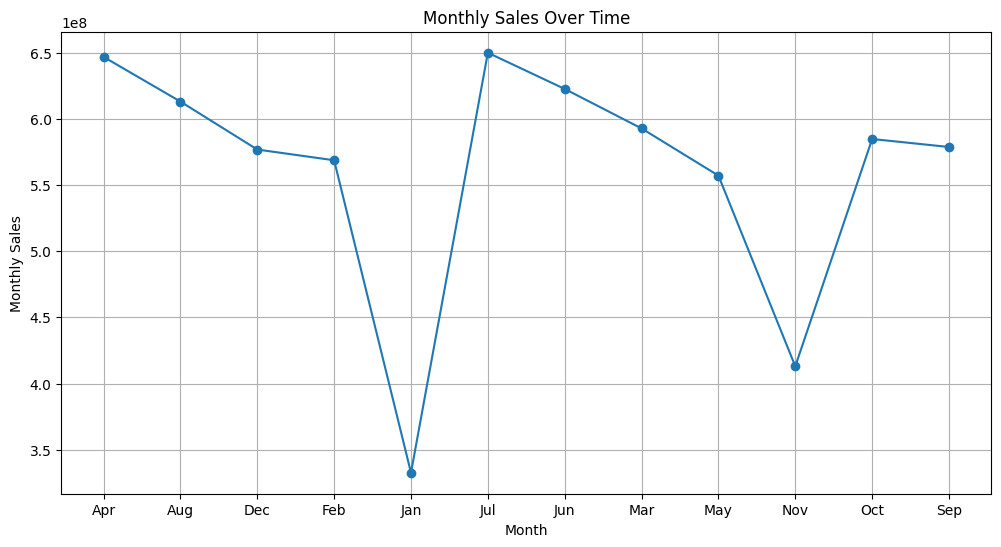

In [16]:
import matplotlib.pyplot as plt

# Group the data by Date and calculate the sum of Weekly Sales for each week
df_weeks = data.groupby('Month')['Weekly_Sales'].sum()
# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(df_weeks.index, df_weeks.values, marker='o', linestyle='-')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.grid(True)

# Display the plot
plt.show()



In [17]:
df_weeks.dtypes

dtype('float64')

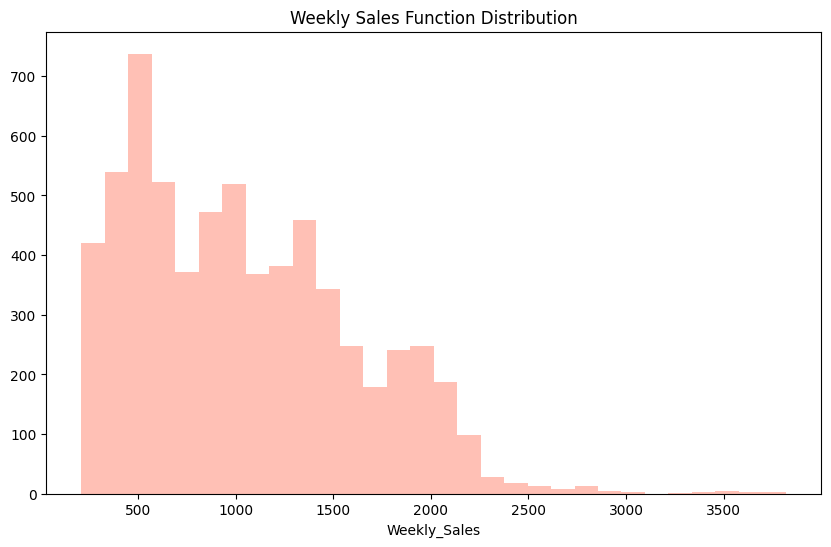

In [18]:
plt.figure(figsize=(10, 6))
data["Weekly_Sales"]=data.Weekly_Sales/1000

sns.distplot(data.Weekly_Sales, kde=False, bins=30, color = 'tomato')
plt.title('Weekly Sales Function Distribution')
plt.show()

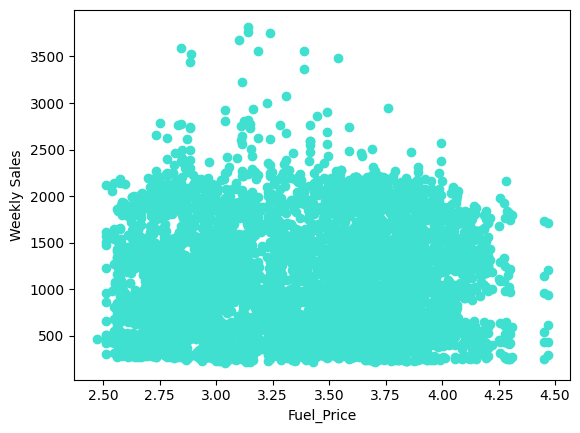

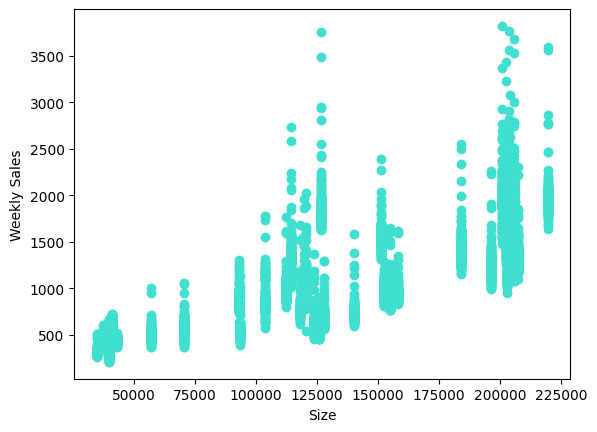

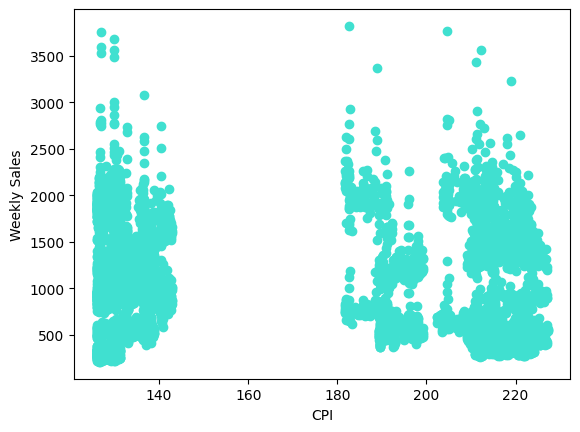

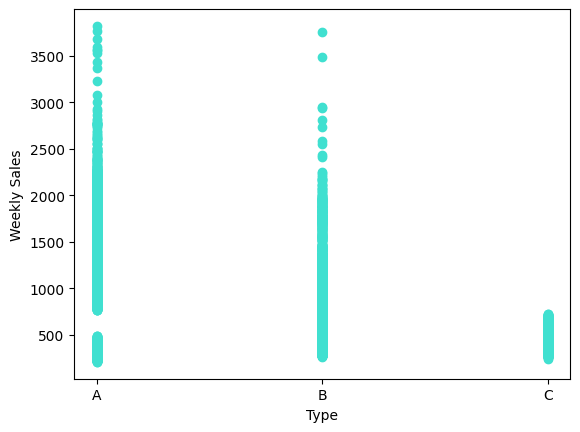

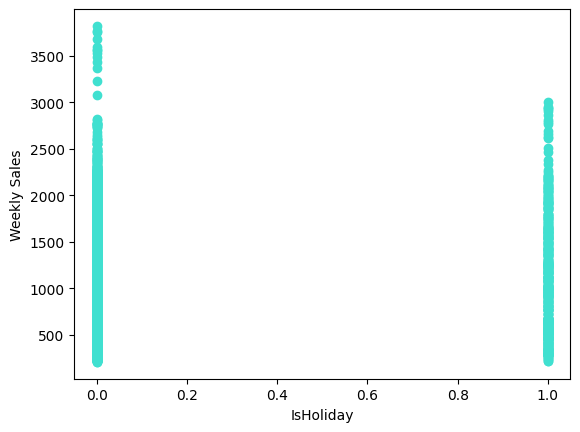

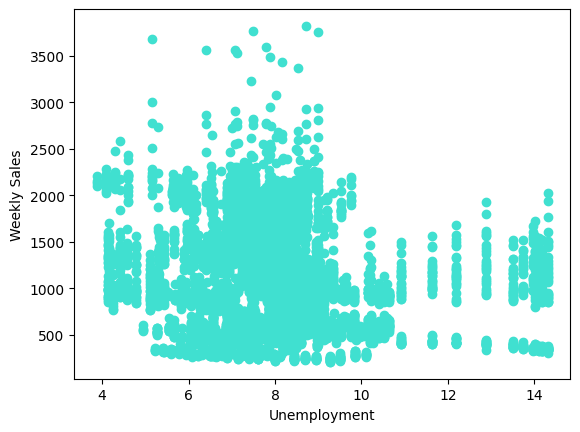

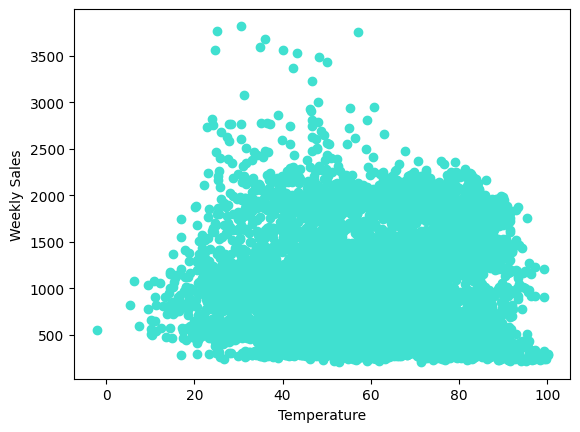

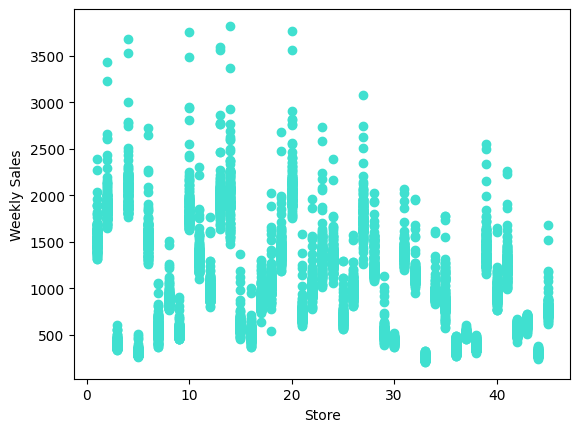

In [19]:
def scatter(dataset, column):
    plt.figure()
    plt.scatter(data[column] , data['Weekly_Sales'], color = 'turquoise')
    plt.ylabel('Weekly Sales')
    plt.xlabel(column)
scatter(data, 'Fuel_Price')
scatter(data, 'Size')
scatter(data, 'CPI')
scatter(data, 'Type')
scatter(data, 'IsHoliday')
scatter(data, 'Unemployment')
scatter(data, 'Temperature')
scatter(data, 'Store')

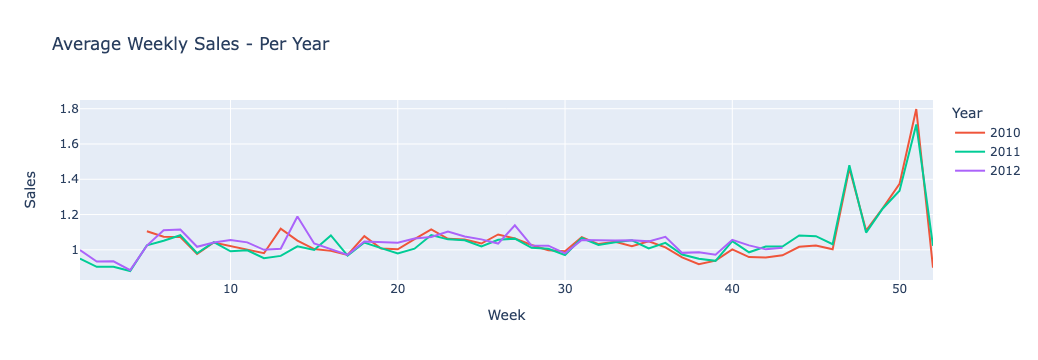

In [23]:
import plotly.express as px

# Assuming 'Date' is the date-time column, make sure it's in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Extract the year and week from the 'Date' column
data['Year'] = data['Date'].dt.year
data['Week'] = data['Date'].dt.isocalendar().week

# Group the data by 'Year' and 'Week' and calculate the mean of 'Weekly_Sales'
weekly_sales_yearly = data.groupby(['Year', 'Week'])['Weekly_Sales'].mean().reset_index()

# Create separate DataFrames for each year
weekly_sales_2010 = weekly_sales_yearly[weekly_sales_yearly['Year'] == 2010]
weekly_sales_2011 = weekly_sales_yearly[weekly_sales_yearly['Year'] == 2011]
weekly_sales_2012 = weekly_sales_yearly[weekly_sales_yearly['Year'] == 2012]

# Create line charts for each year using Plotly Express
fig = px.line(
    title='Average Weekly Sales - Per Year',
    labels={'value': 'Sales', 'variable': 'Year', 'Week': 'Week'},
)

# Add traces for each year's average weekly sales
fig.add_scatter(x=weekly_sales_2010['Week'], y=weekly_sales_2010['Weekly_Sales'], mode='lines', name='2010')
fig.add_scatter(x=weekly_sales_2011['Week'], y=weekly_sales_2011['Weekly_Sales'], mode='lines', name='2011')
fig.add_scatter(x=weekly_sales_2012['Week'], y=weekly_sales_2012['Weekly_Sales'], mode='lines', name='2012')

# Customize the layout
fig.update_layout(
    xaxis_title='Week',
    yaxis_title='Sales',
    legend_title='Year',
)

# Show the chart
fig.show()


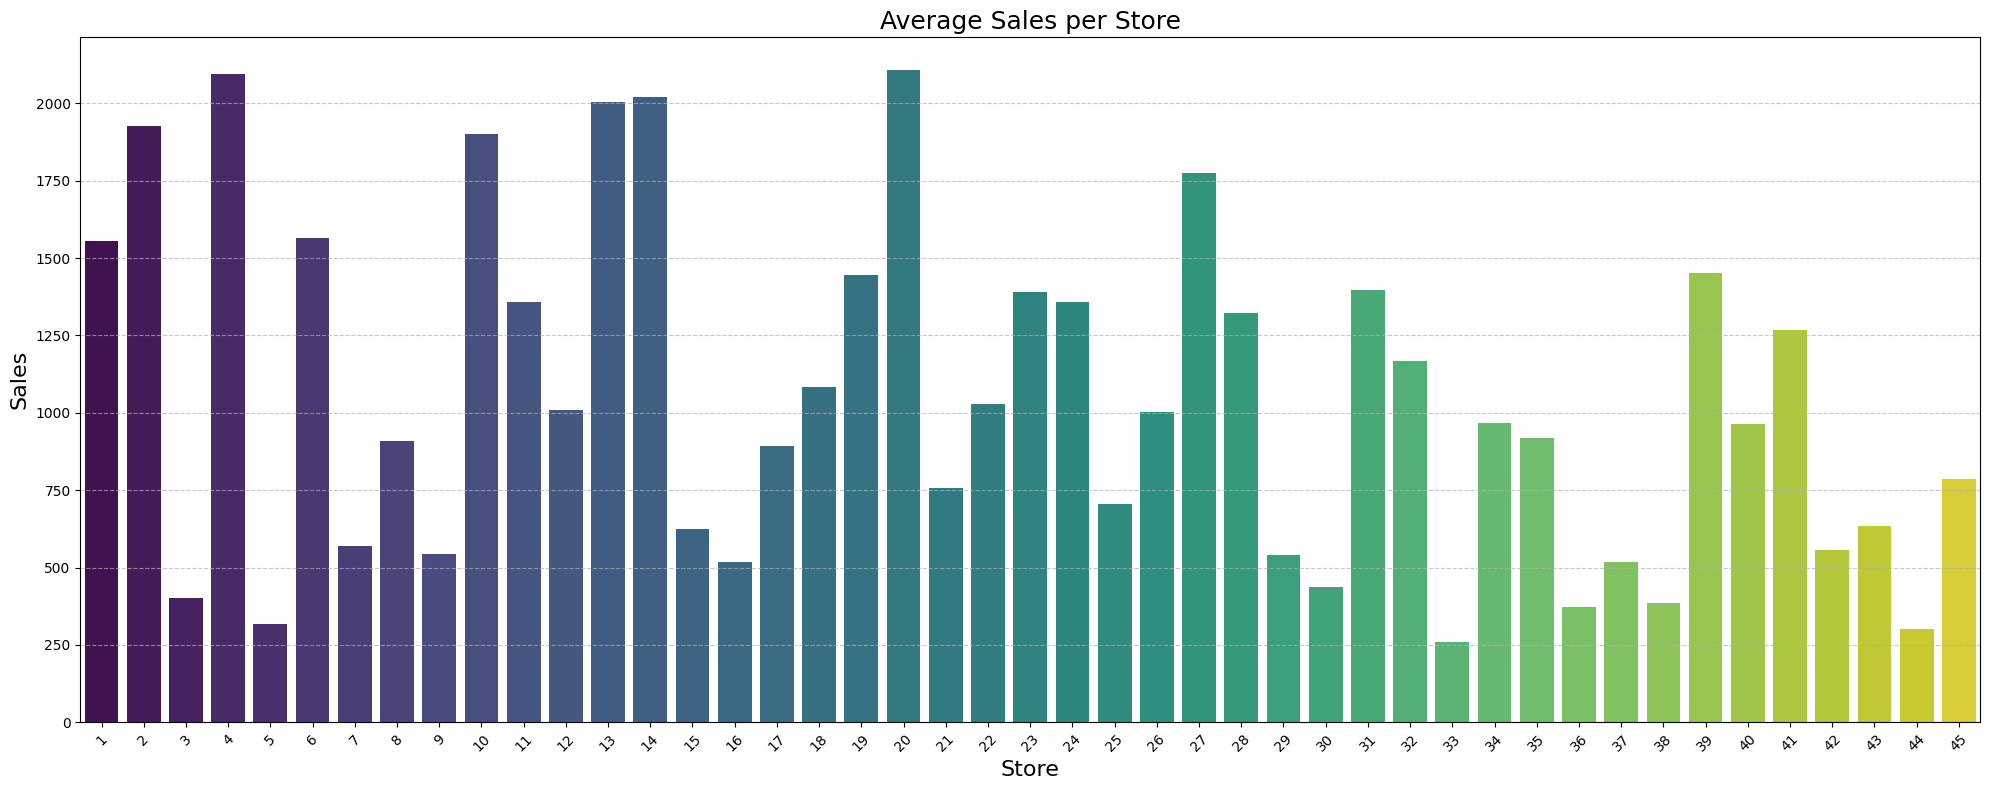

In [20]:
# Calculate the average weekly sales per store
weekly_sales = data.groupby('Store')['Weekly_Sales'].mean()

# Create the bar plot
plt.figure(figsize=(20, 8))
plt.style.use('default')

# Use Seaborn's barplot function
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='viridis')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Average Sales per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()


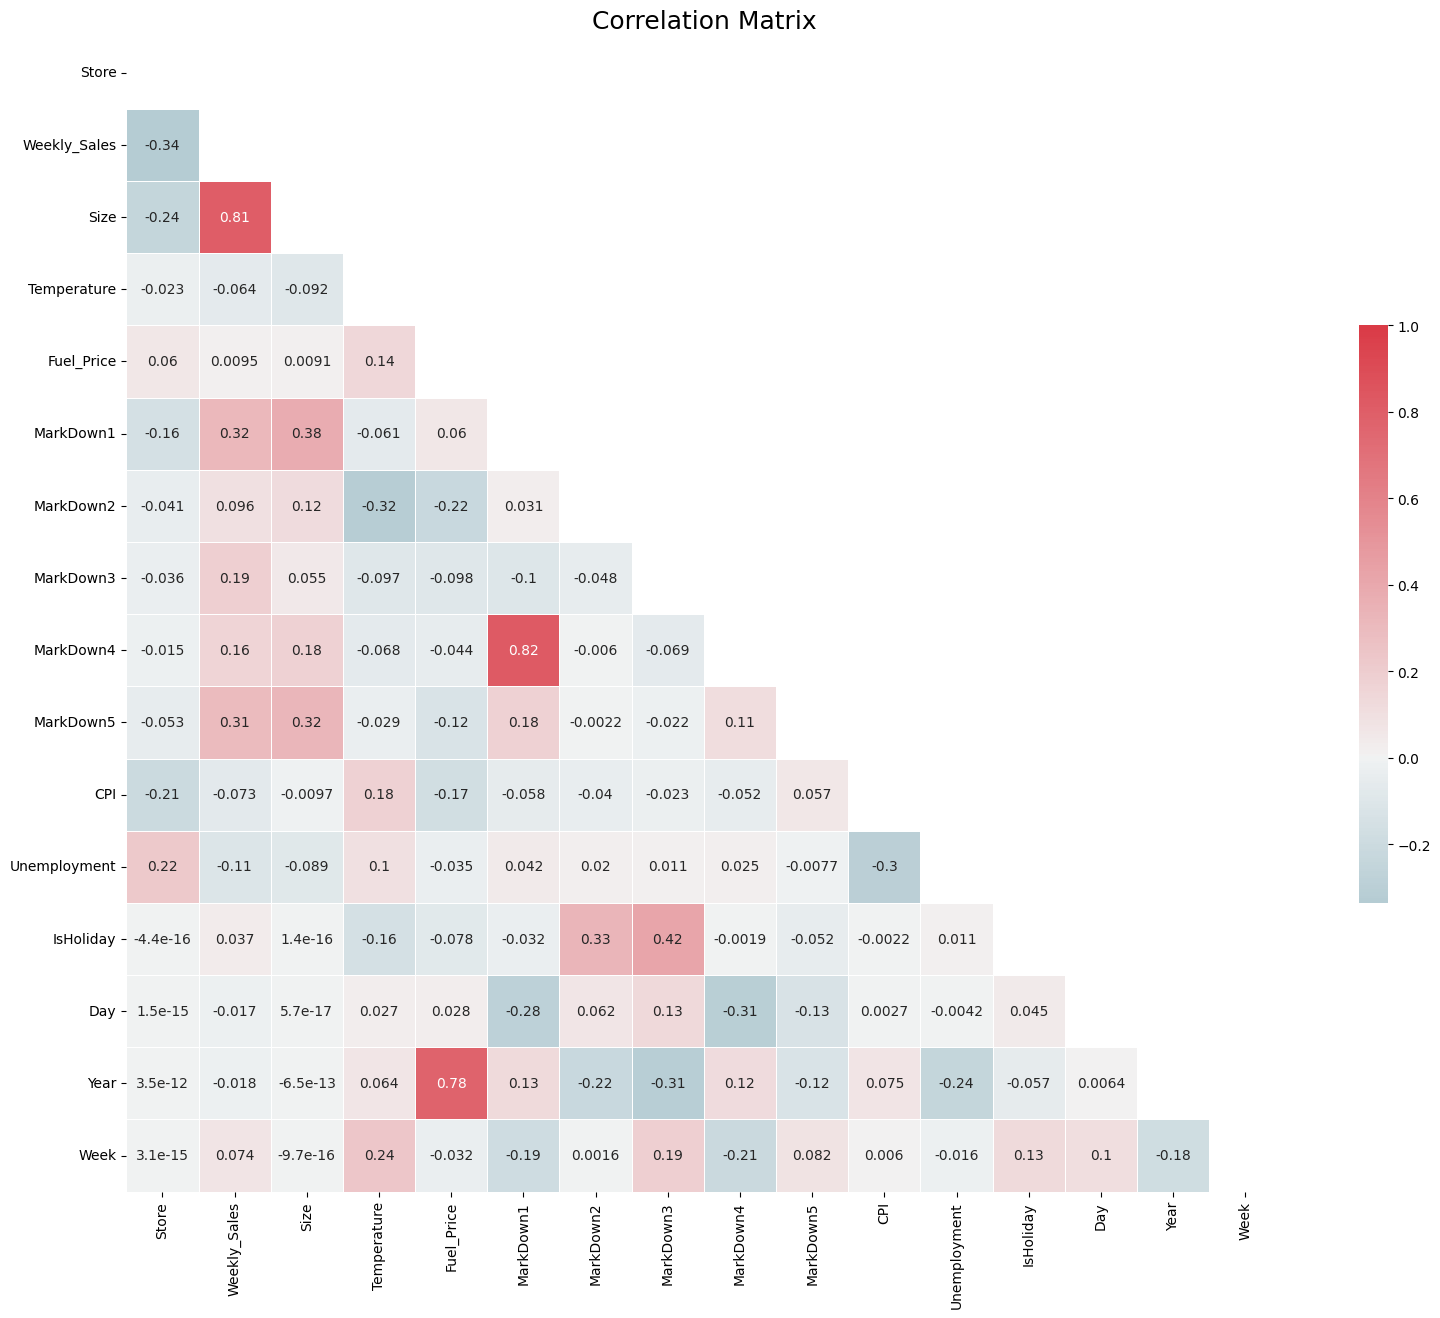

In [22]:
# Exclude non-numeric columns before calculating the correlation matrix
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_data = data[numeric_columns]

# Calculate the correlation matrix
corr = numeric_data.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Define a color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Set plot title and adjust font size
plt.title('Correlation Matrix', fontsize=18)

plt.show()



## Detailed Time-Series Analysis 

Any data that is recorded with some fixed interval of time, is called as Time Series Data. The data can be at a fixed interval of time, it can be hourly, daily, monthly or yearly. 
The main objective of Time Series is to understand how change in time can affect the dependent variables and accordingly predict values for the futured time intervals.  
For this particular case, we are focusing on one store(store 4) and performing a detailed time-series analysis on it. 

In [20]:
data1 = pd.read_csv('train.csv')
data1.set_index('Date', inplace=True)

store4 = data1[data1.Store == 4]
# there are about 45 different stores in this dataset.

sales4 = pd.DataFrame(store4.Weekly_Sales.groupby(store4.index).sum())
sales4.dtypes
sales4.head(20)
# Grouped weekly sales by store 4

#remove date from index to change its dtype because it clearly isnt acceptable.
sales4.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales4['Date'] = pd.to_datetime(sales4['Date'])
# resetting date back to the index
sales4.set_index('Date',inplace = True)

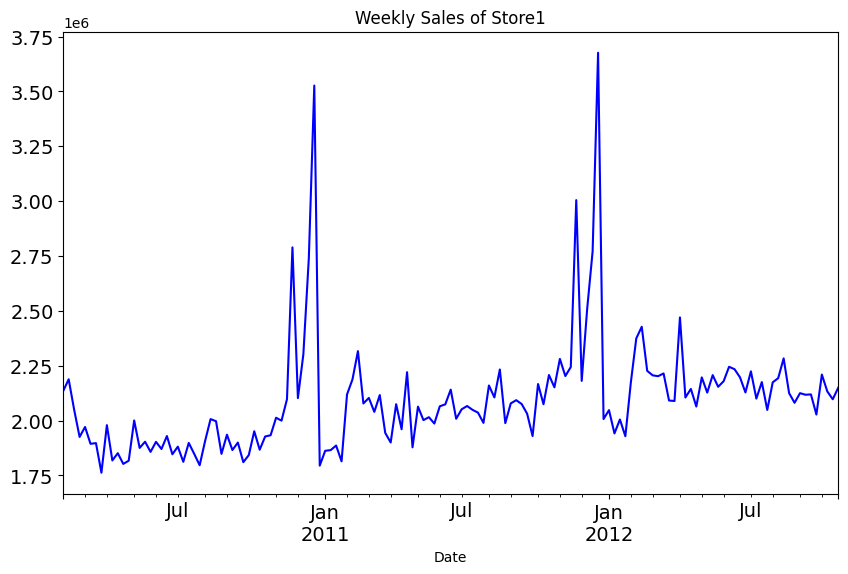

In [21]:
sales4.Weekly_Sales.plot(figsize=(10,6), title= 'Weekly Sales of Store1', fontsize=14, color = 'blue')
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 68.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 47.0 MB/s eta 0:00:00


<Figure size 640x480 with 0 Axes>

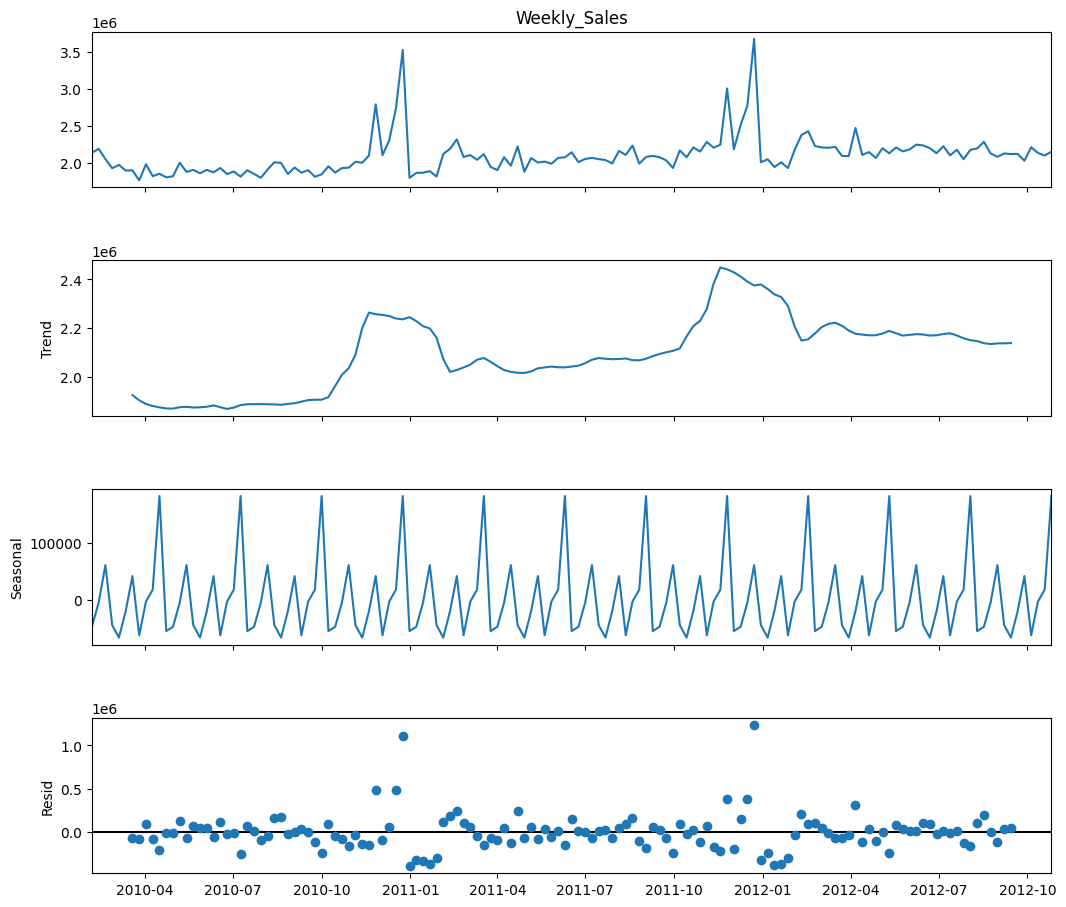

In [22]:
!pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sales4.Weekly_Sales, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

## Multiplicative Decomposition 
An additive model suggests that the components are multipled together.
An additive model is non-linear such as quadratic or exponential.
Changes increase or decrease over time.
A non-linear seasonality has an increasing or decreasing frequency (width of the cycles) and / or amplitude (height of the cycles) over time.


<Figure size 640x480 with 0 Axes>

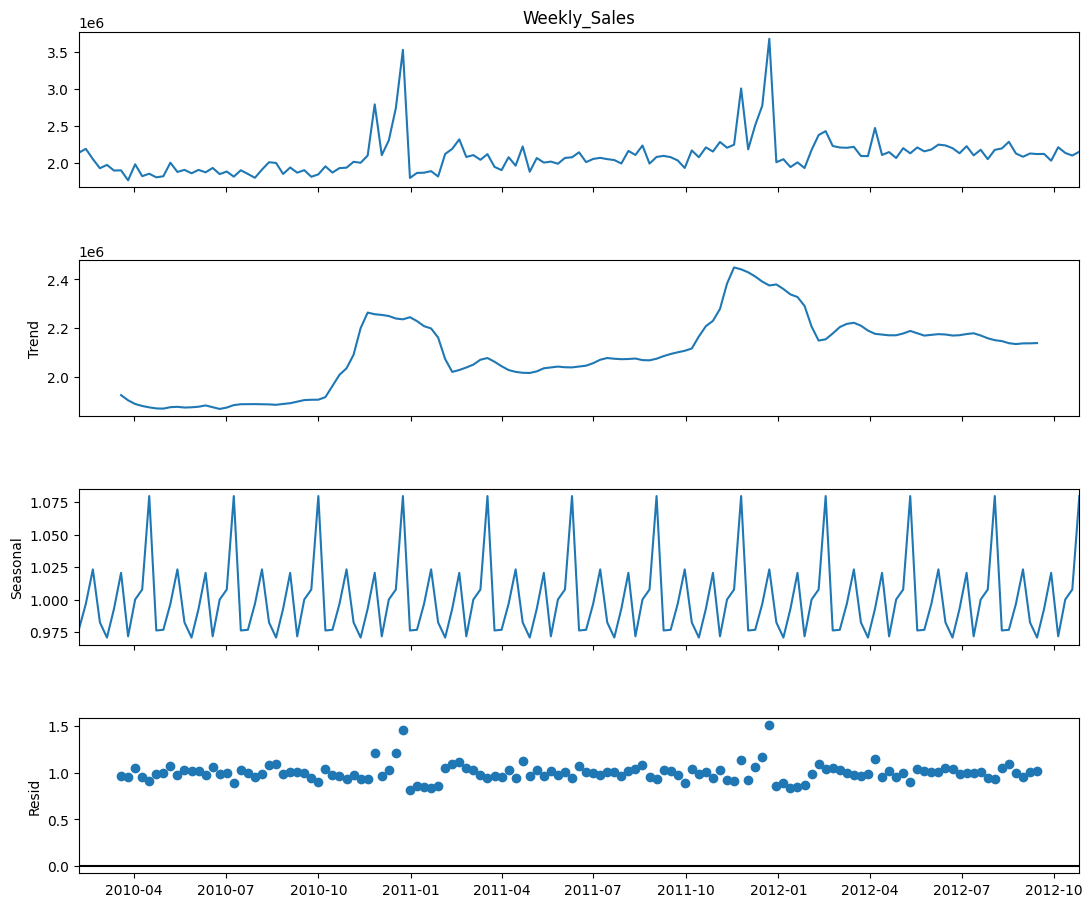

In [23]:
decomposition = seasonal_decompose(sales4.Weekly_Sales, model= 'multiplicative', period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

In [24]:
#Comparing sales from store 4 and store 6
# Lets take store 6 data for analysis
store6 = data1[data1.Store == 6]
# there are about 45 different stores in this dataset.

sales6 = pd.DataFrame(store6.Weekly_Sales.groupby(store6.index).sum())
sales6.dtypes
# Grouped weekly sales by store 6

#remove date from index to change its dtype because it clearly isnt acceptable.
sales6.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales6['Date'] = pd.to_datetime(sales6['Date'])
# resetting date back to the index
sales6.set_index('Date',inplace = True)
y1=sales4.Weekly_Sales
y2=sales6.Weekly_Sales

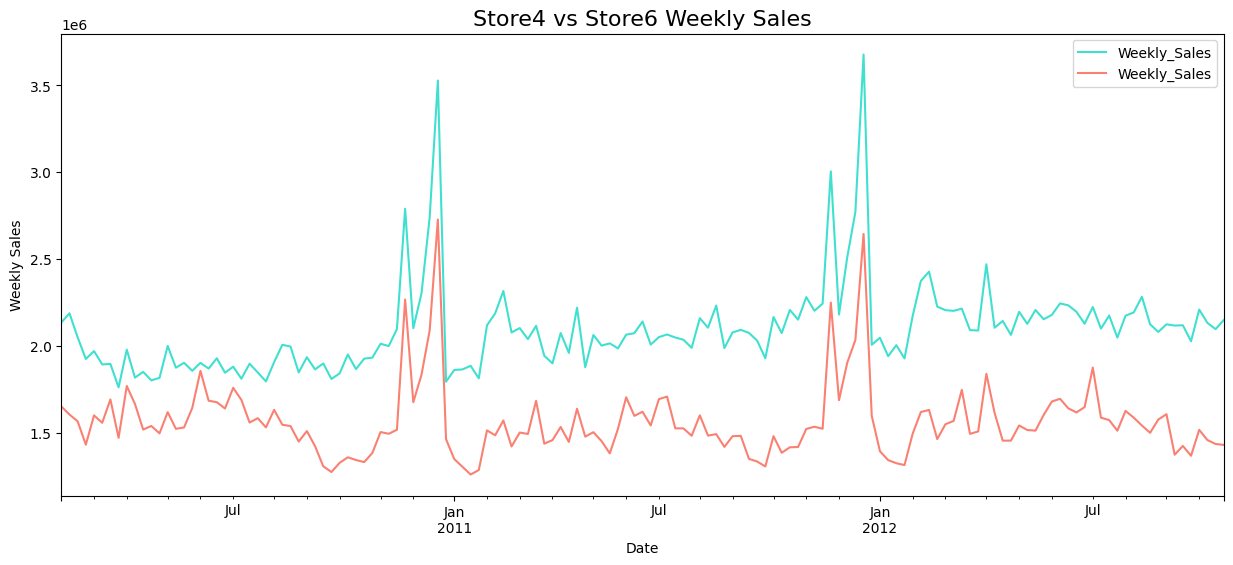

In [25]:
y1.plot(figsize=(15, 6), legend=True, color = 'turquoise')
y2.plot(figsize=(15, 6), legend=True, color = 'salmon')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 Weekly Sales', fontsize = '16')
plt.show()

This shows an interesting trend during year ends (during both 2011 & 2012). The best thing is both the stores have almost the same trends and spike just the magnitude is different
This clearly tells its a timeseries problem and it will be interesting to look more into it

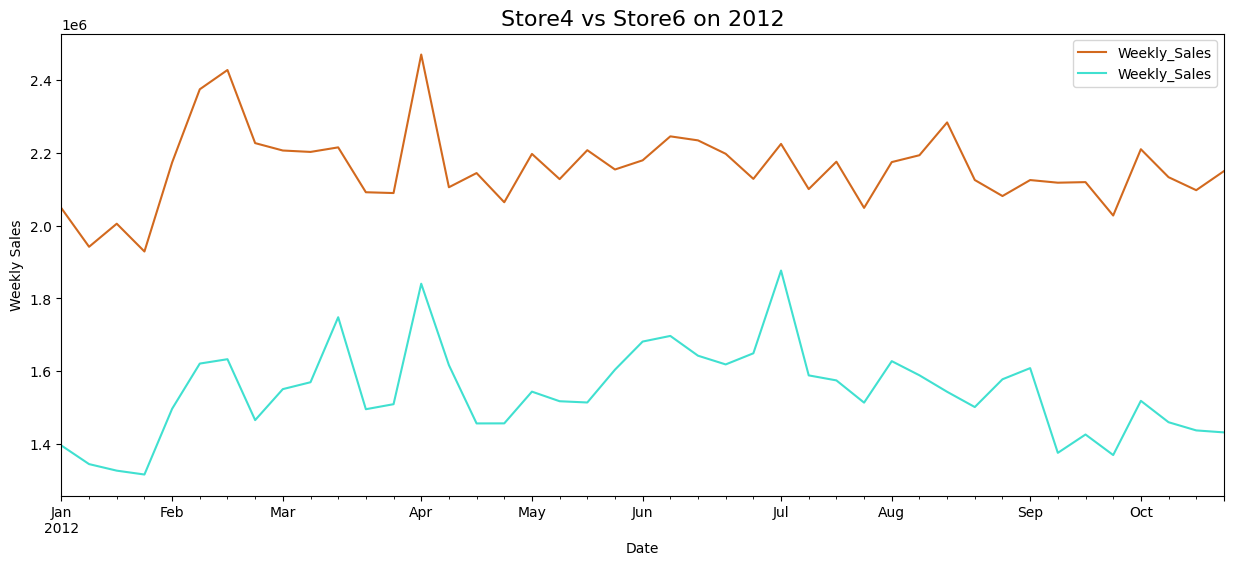

In [26]:
# Lets Look into 2012 data for a better view
y1['2012'].plot(figsize=(15, 6),legend=True, color = 'chocolate')
y2['2012'].plot(figsize=(15, 6), legend=True, color = 'turquoise')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 on 2012', fontsize = '16')
plt.show()


Not quite a trend. Here comes yet another component of timeseries - Irregular component
which are other non random sources of variations of series and are mainly the impact of random events such as strikes, earthquakes, and sudden changes in the weather. By their nature, these effects are completely unpredictable.

In [30]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 5)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [ ]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(y1,
                                order=(4, 4, 3),
                                seasonal_order=(1, 1, 0, 52),   #enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.32190D+00    |proj g|=  2.11788D-01

At iterate    5    f=  8.19196D+00    |proj g|=  3.64631D-01

At iterate   10    f=  8.03865D+00    |proj g|=  1.09208D+00

At iterate   15    f=  7.98422D+00    |proj g|=  3.19650D-01

At iterate   20    f=  7.98334D+00    |proj g|=  9.55541D-02

At iterate   25    f=  7.98301D+00    |proj g|=  5.13009D-02

At iterate   30    f=  7.98253D+00    |proj g|=  2.77669D-01

At iterate   35    f=  7.98218D+00    |proj g|=  2.75702D-02

At iterate   40    f=  7.98217D+00    |proj g|=  4.99852D-03

At iterate   45    f=  7.98212D+00    |proj g|=  3.40274D-02


In [ ]:
plt.style.use('seaborn-pastel')
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [37]:
# Will predict for last 90 days. So setting the date according to that
pred = results.get_prediction(start=pd.to_datetime('2012-07-27'), dynamic=False)
pred_ci = pred.conf_int()

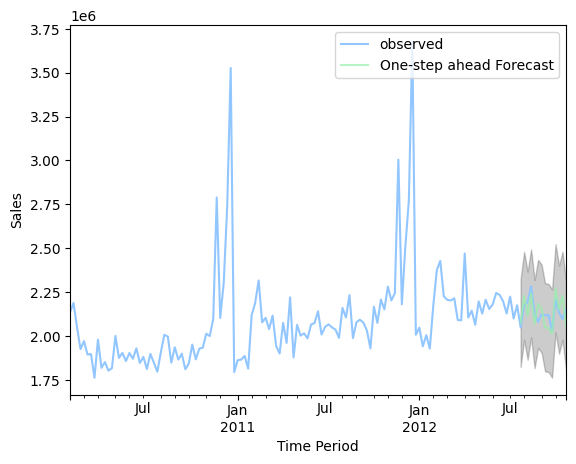

In [38]:
ax = y1['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [39]:
y_forecasted = pred.predicted_mean
y_truth = y1['2012-7-27':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4732600295.02


In [40]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-7-27'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

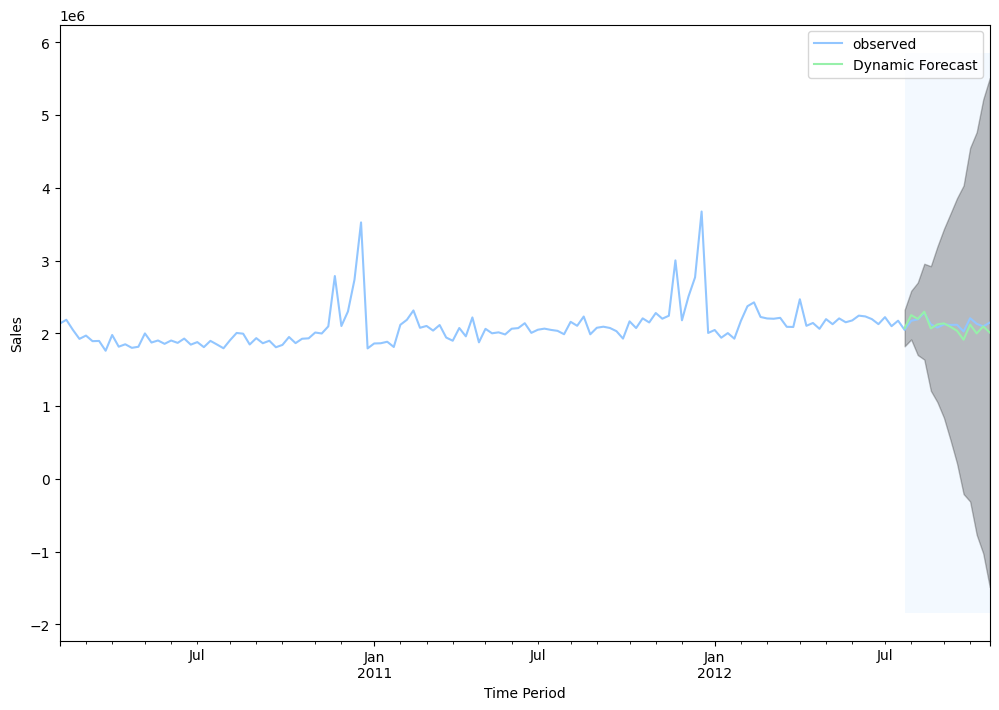

In [41]:
ax = y1['2010':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-7-26'), y1.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

That looks good. Both the observed and predicted lines go together indicating nearly accurate prediction

In [42]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean

y_truth = y1['2012-7-27':]

# Compute the Root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 74160.46


In [43]:
Residual= y_forecasted - y_truth
print("Residual for Store1",np.abs(Residual).sum()))

SyntaxError: unmatched ')' (2941239809.py, line 2)

In [ ]:
# Get forecast 12 weeks ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [ ]:
ax = y1.plot(label='observed', figsize=(12, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

For future prediction the model is not that great because the error interval is way big. But if we just check the green line prediction this is almost like earlier years. If we look for may be first 2 weeks the prediction is way better and error is also low.

#### Plotting Data

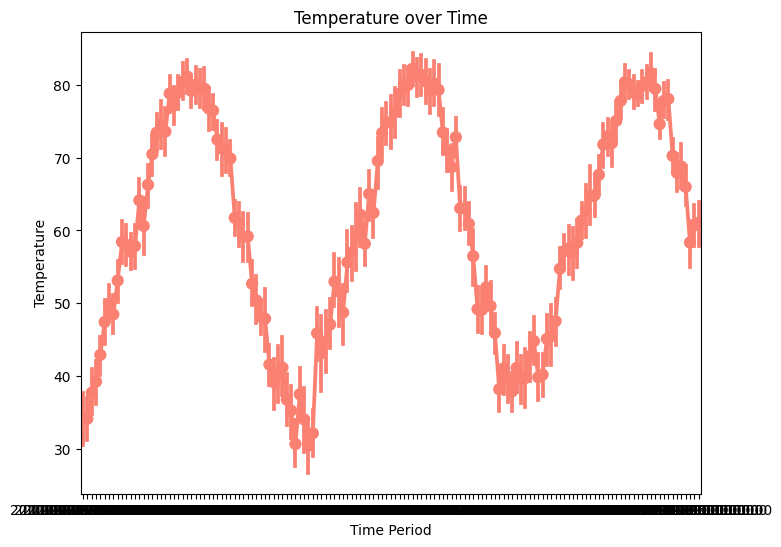

In [27]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Temperature", data=data, color = 'salmon')
plt.xlabel('Time Period')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()

Graph clearly shows Temperature is more of a seasonal and repeated in cycles and this would 
be an interesting data point that we can use for studies further

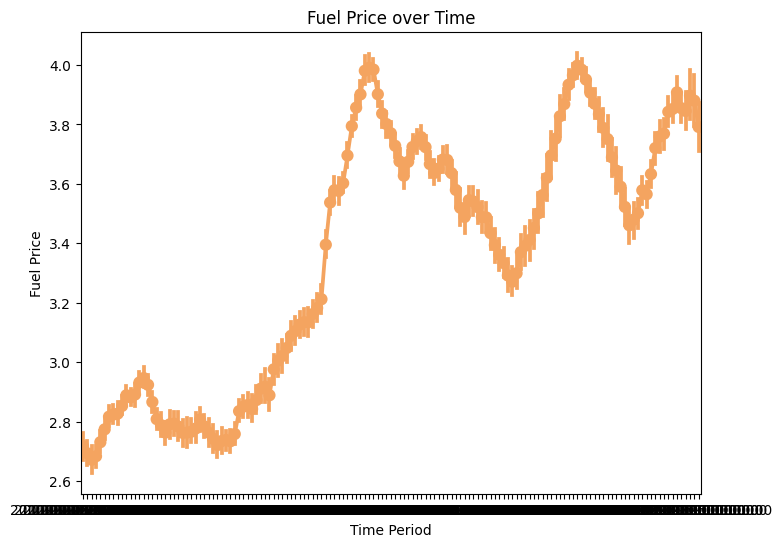

In [28]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Fuel_Price", data=data, color = 'sandybrown')
plt.xlabel('Time Period')
plt.ylabel('Fuel Price')
plt.title('Fuel Price over Time')
plt.show()

inference: Fuel price varies over time and there are high and lows

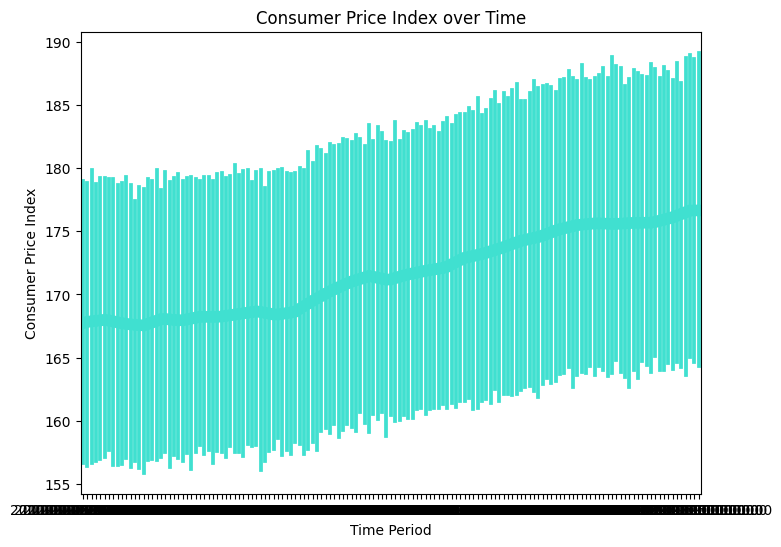

In [30]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="CPI", data=data, color = 'turquoise')
plt.xlabel('Time Period')
plt.ylabel('Consumer Price Index')
plt.title('Consumer Price Index over Time')
plt.show()

inference: over time CPI have increased. but the change is not much

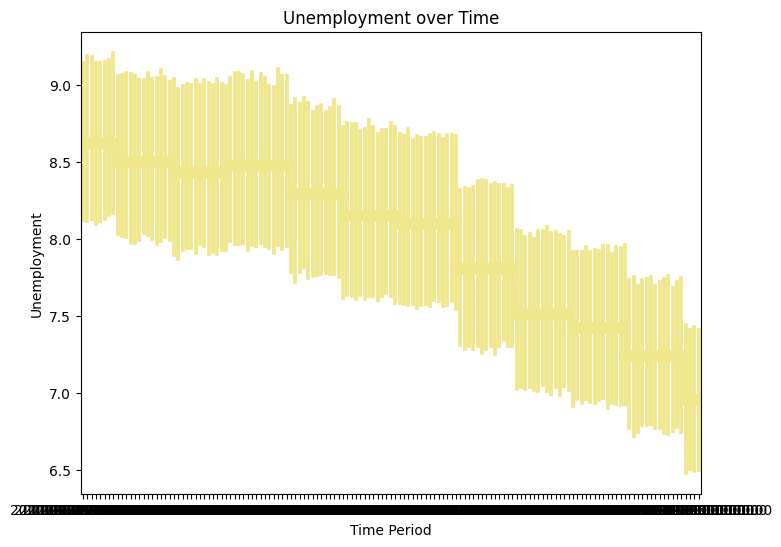

In [31]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Unemployment", data=data, color='khaki')
plt.xlabel('Time Period')
plt.ylabel('Unemployment')
plt.title('Unemployment over Time')
plt.show()

inference:  Over time unemployment have came down we can see this factor also whether it have affected the Sales

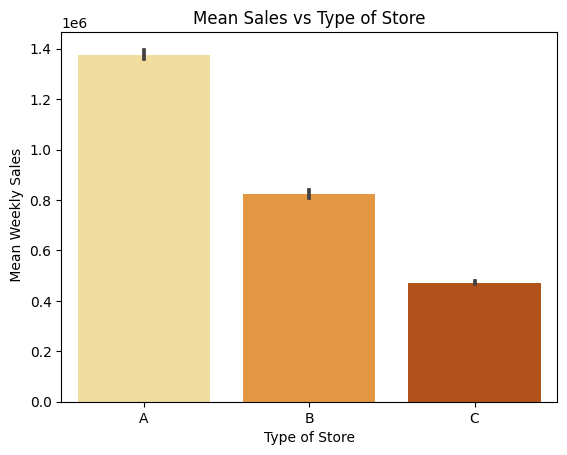

In [32]:
# Checking how the Type of the store have effect on the sales.
col=['coral', 'greenyellow', 'turquoise']
sns.barplot(x="Type", y="Weekly_Sales", data=data,orient='v', palette ='YlOrBr')
plt.xlabel('Type of Store')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean Sales vs Type of Store')
#plt.savefig('./images/Type_vs_Sales.png')
plt.show()

inference: From the graph its clear that Type A > Type B > Type C in mean weekly sales. 

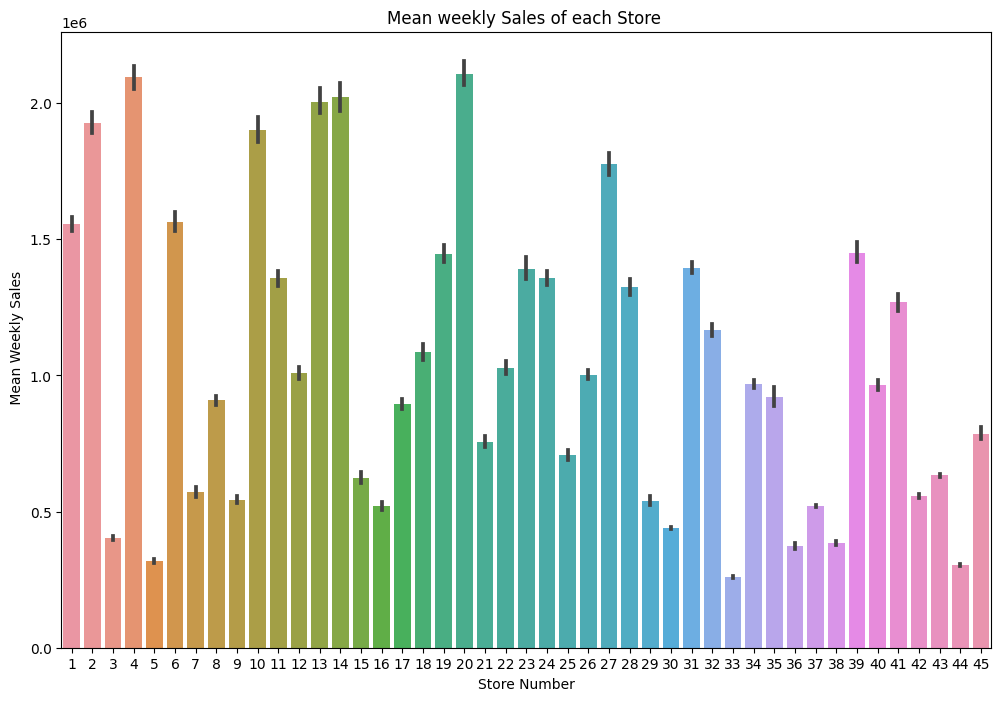

In [17]:
plt.subplots(figsize=(12,8))
sns.barplot(x="Store", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Store Number')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales of each Store ')
#plt.savefig('./images/Mean_Weekly_Sales_vs_Stores.png')
plt.show()

inference : From the chart we can see that there are stores that have a weekly sales from $250,000  
to $2,200,000

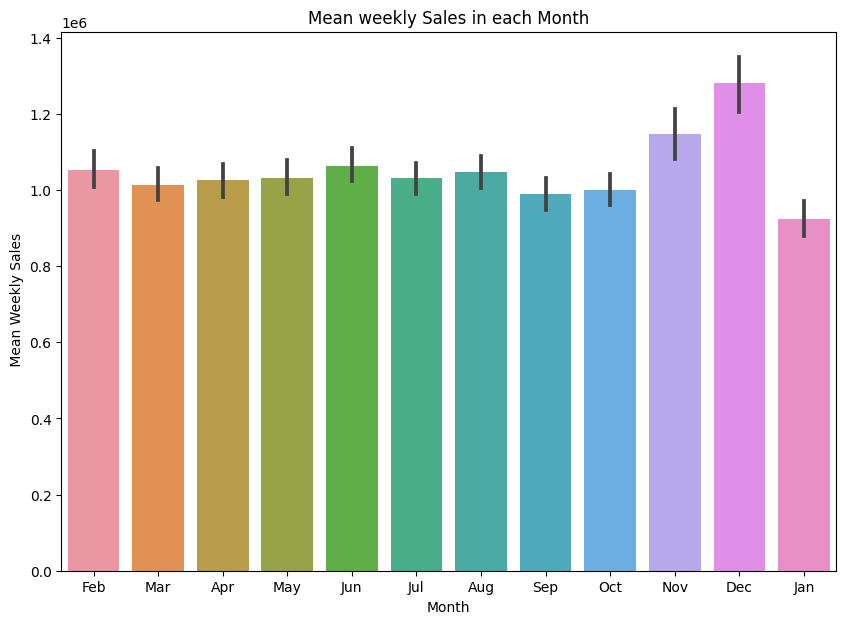

In [35]:
plt.subplots(figsize=(10,7))
sns.barplot(x="Month", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Month')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales in each Month')
#plt.savefig('./images/Mean_Weekly_Sales_vs_Months.png')
plt.show()

Graph shows sales in each month and from this we can see December seems to have a very high sales compared to every other month and January have the least sales. 

In [38]:
for col in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    mean_value = data[col].mean()
    data[col].fillna(mean_value, inplace=True)

In [42]:
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
Day             0
Month           0
Year            0
Week            0
dtype: int64

We will divide our train and test datasets first and then deal with that seperately

In [20]:
# Setting the offset to finalize the test data.
offset = timedelta(days=90)
split_date=data.Date.max()-offset

In [21]:
data_train=data[data.Date < split_date]
data_test=data[data.Date > split_date]

Shuffle the dataframe a bit because while we use crossvalidation for regressors it won't take a random sample as test and train, instead it takes section by section. Here my Dataframe have data for each store in order. So if we take section by section model might not have enough data to learn about certain stores and which intern will give terrible answers

In [22]:
data_train = data_train.reindex(np.random.permutation(data.index))## Identify outliers
data_train.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Type', 'Size', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday', 'Day', 'Month', 'Year',
       'Week'],
      dtype='object')

In [23]:
data_train.dtypes

Store                  float64
Date            datetime64[ns]
Weekly_Sales           float64
Type                    object
Size                   float64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday              float64
Day                    float64
Month                   object
Year                   float64
Week                    UInt32
dtype: object

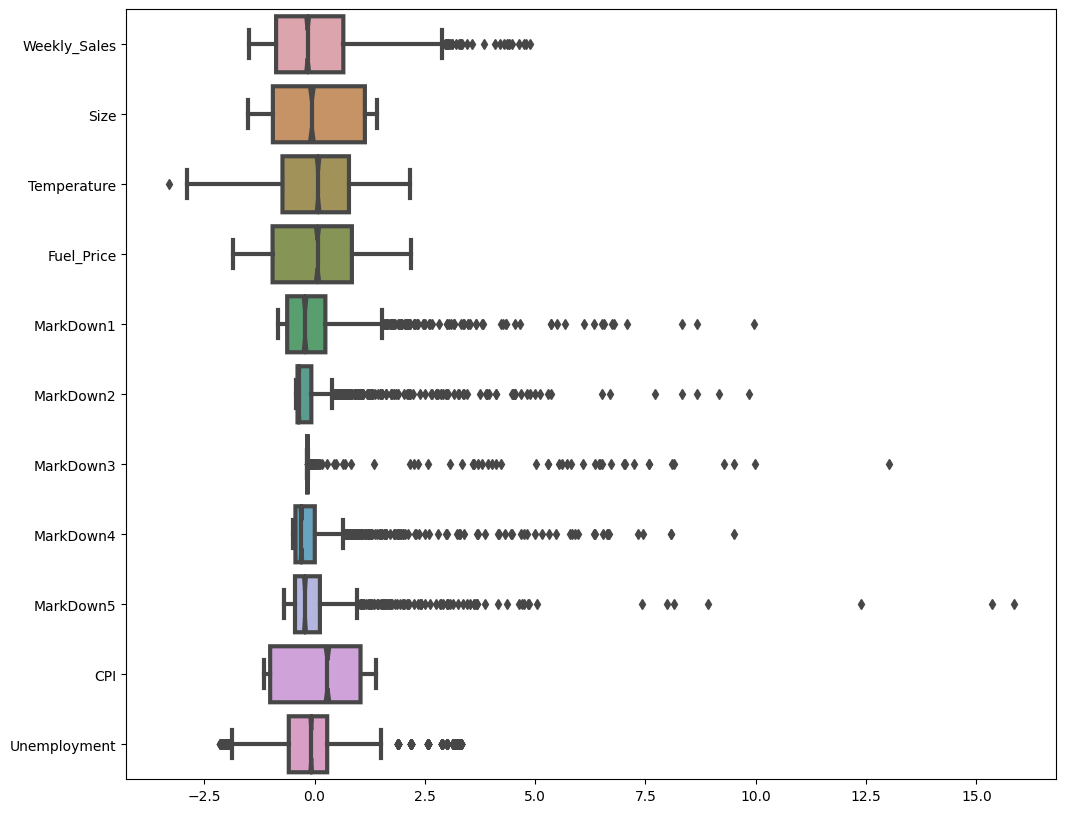

In [24]:
data_box=data_train[['Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 
                       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 
                       'CPI', 'Unemployment']]
data_norm = (data_box - data_box.mean()) / data_box.std()

fig = plt.figure(figsize=(12, 10))
ax = fig.gca()

ax = sns.boxplot(data=data_norm, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

There are quite a lot of outliers in MarkDown, But Lets first deal the outliers in weekly sales data because we might just drop MarkDowns Later because the percentage of missing values are really high in MarkDowns

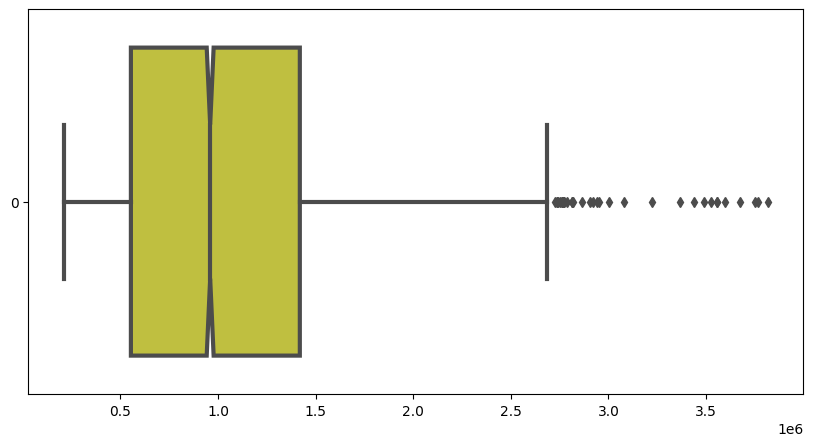

In [55]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

ax = sns.boxplot(data_train.Weekly_Sales, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax, color = 'yellow')
plt.show()

In [57]:
# Lets consider 3,000,000 as upper limit 
data_train[data_train.Weekly_Sales>3000000].shape

(14, 19)

In [58]:
# there is only 14 outliers. Lets drop it and proceed.
data_train=data_train[data_train.Weekly_Sales<3000000]

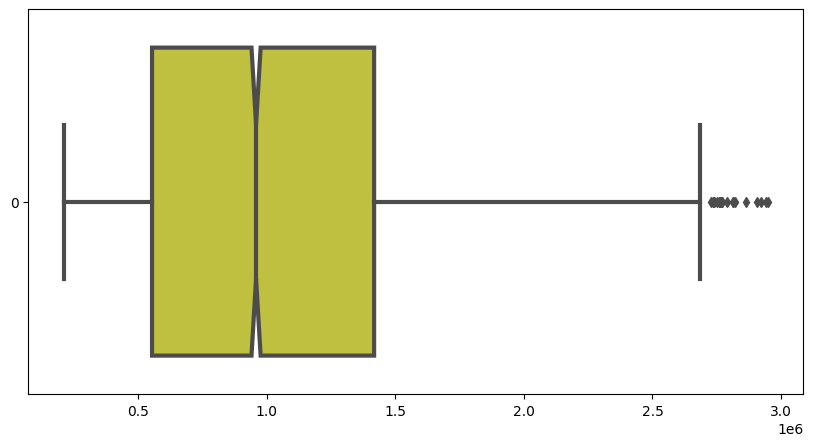

In [59]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

ax = sns.boxplot(data_train.Weekly_Sales, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax, color = 'yellow')
plt.show()

In [77]:
# Exclude categorical columns from predictors
predictors = [col for col in data.columns if data[col].dtype in [np.float64, np.int64] and col not in ['Weekly_Sales', 'Sqrt_Sales', 'lnSales', 'Date']]

In [84]:
from sklearn.preprocessing import OneHotEncoder

# Assuming 'Type' is the only categorical column in predictors
categorical_cols = ['Type']

# One-hot encode the categorical columns
one_hot_encoder = OneHotEncoder()
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_cols])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_cols])

# Convert the encoded features into a DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), index=X_test.index)

# Combine the encoded features with the rest of the predictors
X_train_combined = pd.concat([X_train.drop(columns=categorical_cols), X_train_encoded_df], axis=1)
X_test_combined = pd.concat([X_test.drop(columns=categorical_cols), X_test_encoded_df], axis=1)

# Now apply StandardScaler
# Convert feature names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)
X_train = data_train[predictors]
y_train = data_train.Weekly_Sales.values

X_test = data_test[predictors]
y_test = data_test.Weekly_Sales.values
# Now apply StandardScaler
ss = StandardScaler()
X_train_s = ss.fit_transform(X_train_combined)
X_test_s = ss.transform(X_test_combined)

In [90]:
gb = GradientBoostingRegressor(n_estimators=100,max_depth=10,learning_rate=0.1)
gb.fit(X_train_s, y_train)
gb_scores = cross_val_score(gb, X_train_s, y_train, cv=6)
np.mean(gb_scores)

0.9498621552677727

In [91]:
gb_yhat=gb.predict(X_test_s)
gb_score=gb.score(X_test_s,y_test)

print("R2: ",gb_score)
gb_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-gb_score)
print("Adjusted R2: ",gb_adj_r2)

R2:  0.9659843351144408
Adjusted R2:  0.9652707197671914


In [92]:
train_resids = y_train*1000 - gb.predict(X_train_s)*1000
test_resids = y_test*1000 - gb_yhat*1000
gb_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",gb_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 40360206674.11125
Test Residual 37487101822.35924
Residual ratio of Test to Train 0.9288134256855789


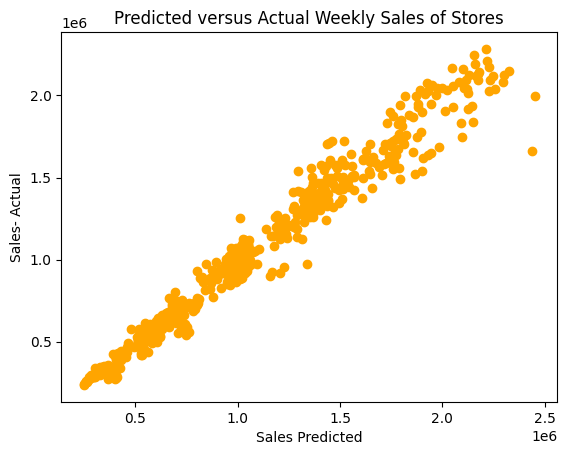

In [99]:
plt.scatter(gb_yhat, y_test, c='orange')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

In [93]:
svr=SVR(C=50000.0, max_iter=500)

svr.fit(X_train_s, y_train)

SVR(C=50000.0, max_iter=500)

In [94]:
svr_scores = cross_val_score(svr, X_train_s, y_train, cv=10)
np.mean(svr_scores)

0.5993284400427829

In [95]:
svr_yhat=svr.predict(X_test_s)
svr_score=svr.score(X_test_s,y_test)
print("R2: ",svr_score)
svr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-svr_score)
print("Adjusted R2: ",svr_adj_r2)

R2:  0.6280759901521427
Adjusted R2:  0.6202733885469428


In [97]:
train_resids = y_train*1000 - svr.predict(X_train_s)*1000
test_resids = y_test*1000 - svr_yhat*1000
svr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual", np.abs(train_resids).sum())
print("Test Residual",svr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 1611104539346.1753
Test Residual 157585040874.20804
Residual ratio of Test to Train 0.09781180365748321


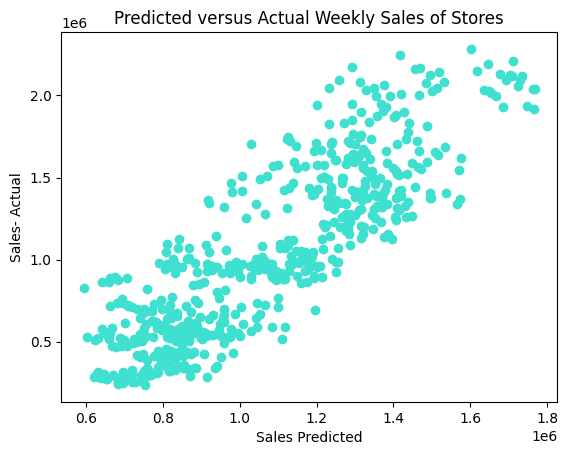

In [98]:
plt.scatter(svr_yhat, y_test, c='turquoise')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

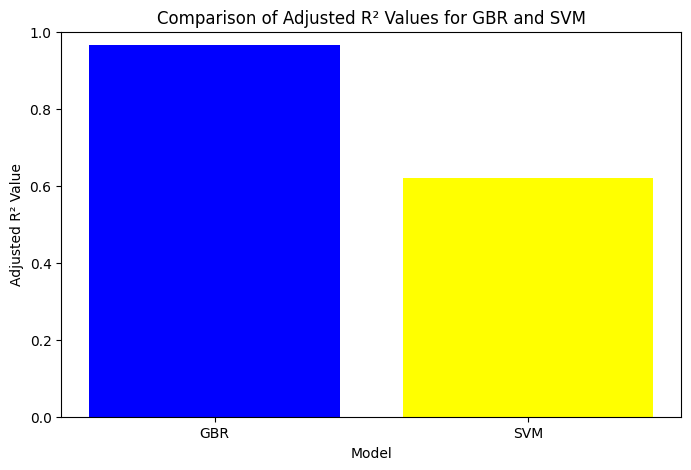

In [19]:
adjusted_r2 = {'GBR': 0.9652707197671914, 'SVM': 0.6202733885469428}

# Names of models
models = list(adjusted_r2.keys())

# Corresponding R2 values
r2_values = list(adjusted_r2.values())

# Creating the bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'yellow'])

# Adding chart labels and title
plt.xlabel('Model')
plt.ylabel('Adjusted R² Value')
plt.title('Comparison of Adjusted R² Values for GBR and SVM')
plt.ylim(0, 1)  # Setting the y-axis limit for better comparison

# Display the plot
plt.show()